
# Exploring contrastive and non-contrastive methods for computer vision

This notebook contains the second exercise for the NORA research summer school on self-supervised learning. The exercise in this notebook is pre-training a convolutional neural network using contrastive and non-contrastive approaches and fine-tuning the network for classification.

The notebook is seperated into several segments with both complete code and code with missing components. Your job is to fill in the missing component.

Remember to enable GPU processing: edit -> notebook settings -> hardware accelerator -> GPU.


In [2]:
#@title Code for importing packages

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from IPython.display import clear_output
from torchvision import datasets, transforms, models
import torch.nn.functional as F

#Creating the data

The following code creates the data and plots some example images. We will use the STL-10 datset ([link torchvision description](https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html), [link official description description](https://cs.stanford.edu/~acoates/stl10/)) in our experiments. Please follow the second link to learn about the dataset.

The data is split into a small, labeled training dataset, a larger unlabeled training dataset, and a labeled dataset for testing.

100%|██████████| 2640397119/2640397119 [02:39<00:00, 16548526.22it/s]


Extracting /content/sample_data/stl10_binary.tar.gz to /content/sample_data
torch.Size([100, 3, 96, 96]) torch.Size([100])


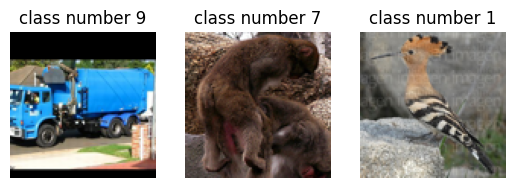

In [5]:
#@title Code for creating dataset

download = False
BATCH_SIZE = 100

dataset = datasets.STL10('/content/sample_data', split='train', download=download, transform=transforms.Compose([transforms.ToTensor()]))
train_set_l, train_set_ul = torch.utils.data.random_split(dataset, [500, 4500])
test_set = datasets.STL10('/content/sample_data', split='test', download=False, transform=transforms.Compose([transforms.ToTensor()]))

train_l_loader = DataLoader(train_set_l, batch_size=BATCH_SIZE, shuffle=True)
train_ul_loader = DataLoader(train_set_ul, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

for img, label in train_l_loader:
    print(img.shape, label.shape)
    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(img[0].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[0]}")
    plt.subplot(1,3,2)
    plt.imshow(img[1].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[1]}")
    plt.subplot(1,3,3)
    plt.imshow(img[2].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[2]}")
    break

In [6]:
#@title creating classification network and self-supervised network.

class clf_network(nn.Module):
    def __init__(self):
        super(clf_network, self).__init__()

        r18 = models.resnet18()
        modules = list(r18.children())[:-1]
        self.encoder = nn.Sequential(*modules, nn.Flatten())

        self.classification_head = nn.Sequential(
                nn.Linear(512, 100),
                nn.ReLU(),
                nn.Linear(100, 10))

    def forward(self, x):

      encoder_out = self.encoder(x)
      predictions = self.classification_head(encoder_out)

      return predictions


class ss_network(nn.Module):
    '''
    SSL Pretraining network
    '''
    def __init__(self):
        super(ss_network, self).__init__()

        r18 = models.resnet18()
        modules = list(r18.children())[:-1]
        self.encoder = nn.Sequential(*modules, nn.Flatten())

        self.projection_head = nn.Sequential(
            nn.Linear(512, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 500))

    def forward(self, x):

      representation = self.encoder(x)
      embeddings = self.projection_head(representation)

      return representation, embeddings




In [7]:
#@title Function for evaluating representation quality using a 1-nearest neighbor classifier.

from sklearn.neighbors import KNeighborsClassifier

def to_np(x):
    return x.cpu().detach().numpy()



def evaluate_encoder_representation(model, training_set, test_set):
    '''
    This is a clustering algorithm that can be used to evaluate how well the latent space learned the data
    It can be run every nth epoch during pre training on the labeled training (x_tr_l) an dthe test data (x_te)
    '''

    model.eval()
    model = model.to('cpu')

    N_tr = len(training_set)
    N_te = len(test_set)

    training_generator = DataLoader(training_set, batch_size=1,
                                    shuffle=True, drop_last=False)
    test_generator = DataLoader(test_set, batch_size= 1,
                                    shuffle=True, drop_last=False)

    H_tr = torch.zeros((N_tr, 128))
    y_tr = torch.zeros((N_tr), dtype=torch.long)

    H_te = torch.zeros((N_te, 128))
    y_te = torch.zeros((N_te), dtype=torch.long)

    for idx_tr, (x_tr, y_tr_i) in enumerate(training_generator):
        with torch.no_grad():
            H_tr_i, _  = model(x_tr.float())
            H_tr[idx_tr] = H_tr_i
            y_tr[idx_tr] = y_tr_i

    H_tr = to_np(nn.functional.normalize(H_tr))
    y_tr = to_np(y_tr)

    for idx_te, (x_te, y_te_i) in enumerate(test_generator):
        with torch.no_grad():
            _, H_te_i = model(x_te.float())
            H_te[idx_te] = H_te_i
            y_te[idx_te] = y_te_i

    H_te = to_np(nn.functional.normalize(H_te))
    y_te = to_np(y_te)

    clf = KNeighborsClassifier(n_neighbors=1).fit(H_tr, y_tr)

    return clf.score(H_te, y_te)



#Self-supervised learning using siamese and a contrastive learning

Your task is to implement the following self-supervised frameworks:


*   [SimSiam](https://arxiv.org/abs/2011.10566)
*   [SimCLR](https://arxiv.org/abs/2002.05709)



In [8]:
#@title Augemntation operation
def augment(in_tensor, crop_size=64):
    # TODO: This should have both color distribution distortion and cropping (see notes of day 2)
    return transforms.RandomCrop(crop_size)(in_tensor)

'''
transforms = torch.nn.Sequential(
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)
scripted_transforms = torch.jit.script(transforms)
'''

'\ntransforms = torch.nn.Sequential(\n    transforms.CenterCrop(10),\n    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),\n)\nscripted_transforms = torch.jit.script(transforms)\n'

In [9]:
#@title Contrastive Loss
def temp_scaled_cross_entropy(positive_comparison_distances, negative_comparison_distances_cumulative, tau):
    sample_wise_losses = -torch.log(torch.exp(positive_comparison_distances / tau) / (torch.exp(negative_comparison_distances_cumulative) / tau))
    reduced_loss = torch.mean(sample_wise_losses)
    return reduced_loss


In [ ]:
#@title Code for self-supervised pretraining.


from IPython.display import clear_output
EPOCHS = 200
USE_PRETRAINED_WEIGHTS = False


model = ss_network()
model = model.to('cuda')

if USE_PRETRAINED_WEIGHTS:
  model.encoder.load_state_dict("fill name of your network".encoder.state_dict())


LossList, AccuracyList = [], []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#
tau = 0.5

print('Training starts!')
for epoch in range(EPOCHS):

    model.train()
    optimizer.zero_grad()

    for x_tr_ul, _ in train_ul_loader:
        x_tr_ul = x_tr_ul.to('cuda')

        x_tr_ul_aug1 = augment(x_tr_ul)
        x_tr_ul_aug2 = augment(x_tr_ul)

        '''
        We implement the normalized temperature-scaled cross-entropy loss (see icloud notes or SIMclr paper)
        The cosine similarity returns a similarity matrix between the two batches
        The comparison scores of positive samples lie on the diagonal of the matrix
        The scores of negative samples lie outside
        --> Along the batch dimension pick out the value on the diagonal for positive score s(z_i, z_j)
        and sum up the loss along batch dimension to get negative sample compatrison scaore s(z_i, z_k)

        --> The task can be solved by either making "Zähler" (denominator?), so similarity very large
        or dissimilarity in "nenner" really low
        '''
        # Get output of projection head
        _, h1 = model(x_tr_ul_aug1)
        _, h2 = model(x_tr_ul_aug2)

        '''
        h1_norm * h1_norm.T
        '''
        # Create cosine similarity score (by hand as torch's implementation is element-wise)

        #cos = nn.CosineSimilarity(dim=0)
        #similarity_matrix = cos(h1, h2)

        h1_norm = nn.functional.normalize(h1, dim=1) # Normalize along sample dim (=1), not batch dim!
        h2_norm = nn.functional.normalize(h2, dim=1)
        # cosine_similarity_matrix = torch.mm(h2_norm.t(), h1_norm)
        # Create similarity matrix with shape batch_size x batch_size.
        # Compares all samples within one batch
        cosine_similarity_matrix = torch.mm(h1_norm, h2_norm.t())
        # Normalize matrix in a way that all rows add up to one to get probabilities
        # cosine_similarity_matrix = F.normalize(cosine_similarity_matrix, p=1, dim=1)
        cosine_similarity_matrix = cosine_similarity_matrix / torch.sum(cosine_similarity_matrix, dim=1, keepdim=True)

        unity = torch.eye(cosine_similarity_matrix.shape[0], cosine_similarity_matrix.shape[1], device='cuda')
        #unity = unity.bool()
        #print(cosine_similarity_matrix)
        #print(unity.argmax(1))
        #raise
        loss = criterion(cosine_similarity_matrix, unity.argmax(1))


        '''
        Infos about the similarity matrix:
        All rows in the matrix have to sum up to one to get probabilities!
        In the original paper they calculate a matrix to compare h1_norm to h1_norm (to get more negative samples) and one to compare h1_norm to h2_norm
        Then they concetenate both matricies. For Calculating the positive samples only the samples along the diagonal of the h1_norm to h2_norm matrix
        are calculated. For calculating the negative samples the diagonals of both matricies have be set to 0.
        '''

        # Masking with unity#
        # All positive comparisons on diagonal, all negative (comparison of other random samples in the batch) outside of diagonal
        #positive_comparison_distances = cosine_similarity_matrix[unity]
        # !!! TODO: CHECK WHETHER BELOW WORKS !!!
        #cosine_similarity_matrix_unity_zero = cosine_similarity_matrix
        #cosine_similarity_matrix_unity_zero[unity] = 0
        # Summing up all negative distances along one sample axis
        # (all samples in one row of similarity matrix except for the ones lying on the diagonal)
        # Make sure, that this is done along the rows as only they add up to one (dim=1)!!
        #negative_comparison_distances_cumulative = torch.sum(cosine_similarity_matrix_unity_zero, dim=1)
        # breakpoint()

        #loss_old = temp_scaled_cross_entropy(positive_comparison_distances,
        #                                 negative_comparison_distances_cumulative,
        #                                 tau)

        #y_tr_pred = model(x_tr)

        #loss = criterion(y_tr_pred, y_tr)
        loss.backward()
        optimizer.step()

        LossList.append(loss.item())

    #with torch.no_grad():
    #    AccListBatch = []
    #    model.eval()
    #    for x_te, y_te in test_loader:
    #        x_te, y_te = x_te.to('cuda'), y_te.to('cuda')
    #        y_te_pred = model(x_te)
    #        AccListBatch.append(torch.sum(y_te_pred.argmax(1) == y_te) / len(y_te))
    #    AccuracyList.append(torch.mean(torch.tensor(AccListBatch)).item())

    #if epoch % 10 == 0 and epoch != 0: clear_output()
    print("Epoch: {}, loss: {}".format(epoch, LossList[-1]))

plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.plot(LossList, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.subplot(122)

plt.show()



Training starts!
Epoch: 0, loss: 4.603457927703857
Epoch: 1, loss: 4.603903770446777
Epoch: 2, loss: 4.602853775024414
Epoch: 3, loss: 4.603531837463379
Epoch: 4, loss: 4.6029863357543945
Epoch: 5, loss: 4.602149963378906
Epoch: 6, loss: 4.601965427398682
Epoch: 7, loss: 4.602303504943848
Epoch: 8, loss: 4.601416110992432
Epoch: 9, loss: 4.602395534515381
Epoch: 10, loss: 4.601712226867676
Epoch: 11, loss: 4.602279186248779
Epoch: 12, loss: 4.602290630340576
Epoch: 13, loss: 4.601470470428467
Epoch: 14, loss: 4.601769924163818
Epoch: 15, loss: 4.600847244262695
Epoch: 16, loss: 4.598720073699951
Epoch: 17, loss: 4.599639415740967
Epoch: 18, loss: 4.600727081298828
Epoch: 19, loss: 4.601095676422119
Epoch: 20, loss: 4.599879264831543
Epoch: 21, loss: 4.599062919616699
Epoch: 22, loss: 4.599451065063477
Epoch: 23, loss: 4.599103927612305
Epoch: 24, loss: 4.601311206817627
Epoch: 25, loss: 4.599720001220703
Epoch: 26, loss: 4.599155426025391
Epoch: 27, loss: 4.599615573883057
Epoch: 28, l


# Downstream task: classification.

This notebook contains the second exercise for the NORA research summer school on self-supervised learning. The exercise in this notebook is pre-training a convolutional neural network using contrastive and non-contrastive approaches and fine-tuning the network for classification.

The notebook is seperated into several segments with both complete code and code with missing components. Your job is to fill in the missing component.

Remember to enable GPU processing: edit -> notebook settings -> hardware accelerator -> GPU.


Epoch: 40, loss: 0.19262681901454926, accuracy: 0.3036249876022339
Epoch: 41, loss: 0.08195008337497711, accuracy: 0.3501250147819519
Epoch: 42, loss: 0.4421648681163788, accuracy: 0.3307500183582306
Epoch: 43, loss: 0.08885282278060913, accuracy: 0.3076249957084656
Epoch: 44, loss: 0.378465473651886, accuracy: 0.3212500214576721
Epoch: 45, loss: 0.05689055100083351, accuracy: 0.3307500183582306
Epoch: 46, loss: 0.1475604772567749, accuracy: 0.3161250054836273
Epoch: 47, loss: 0.03341491147875786, accuracy: 0.3571249842643738
Epoch: 48, loss: 0.1348925232887268, accuracy: 0.3661249577999115
Epoch: 49, loss: 0.02675871178507805, accuracy: 0.3672499656677246


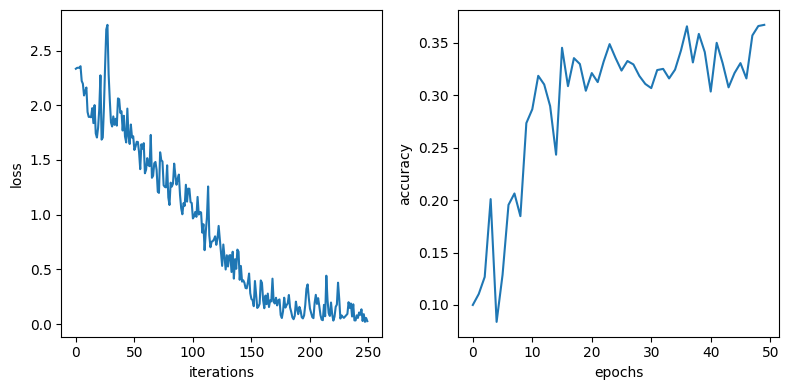

In [54]:
#@title Training code for downstream task.

from IPython.display import clear_output
EPOCHS = 50
USE_PRETRAINED_WEIGHTS = True

pretrained_model = model

model = clf_network().to('cuda')

if USE_PRETRAINED_WEIGHTS:
  model.encoder.load_state_dict(pretrained_model.encoder.state_dict())


LossList, AccuracyList = [], []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print('Training starts!')
for epoch in range(EPOCHS):

    model.train()
    optimizer.zero_grad()

    for x_tr, y_tr in train_l_loader:
        x_tr, y_tr = x_tr.to('cuda'), y_tr.to('cuda')

        y_tr_pred = model(x_tr)

        loss = criterion(y_tr_pred, y_tr)
        loss.backward()
        optimizer.step()

        LossList.append(loss.item())

    with torch.no_grad():
        AccListBatch = []
        model.eval()
        for x_te, y_te in test_loader:
            x_te, y_te = x_te.to('cuda'), y_te.to('cuda')
            y_te_pred = model(x_te)
            AccListBatch.append(torch.sum(y_te_pred.argmax(1) == y_te) / len(y_te))
        AccuracyList.append(torch.mean(torch.tensor(AccListBatch)).item())

    if epoch % 10 == 0 and epoch != 0: clear_output()
    print(f"Epoch: {epoch}, loss: {LossList[-1]}, accuracy: {AccuracyList[-1]}")

plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.plot(LossList, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(AccuracyList, label='accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()